In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

In [2]:
df = pd.read_csv('./query_results.csv')
df.shape

(53, 12)

In [3]:
df.head()

,qry_file_paths,exists,doc_file_paths,return_doc_id,transforms_plot,point_matching_path,idx_rank,idx_score,verif_rank,verif_score,label,time_taken
0,./final_cropped_aoi/_10.mp4_8220.png,True,./final_optimal_gt/_10.mp4_8220.png,0,./results3/transforms/query_transforms_0.png,./results3/matches/point_match_0.png,1,286,1,2298,0,0 days 00:02:15.083603
1,./final_cropped_aoi/_10.mp4_8300.png,True,./final_optimal_gt/_10.mp4_8300.png,1,./results3/transforms/query_transforms_1.png,./results3/matches/point_match_1.png,2,659,1,3626,1,0 days 00:04:56.980618
2,./final_cropped_aoi/_10.mp4_8465.png,True,./final_optimal_gt/_10.mp4_8465.png,2,./results3/transforms/query_transforms_2.png,./results3/matches/point_match_2.png,1,642,1,3642,2,0 days 00:04:36.268085
3,./final_cropped_aoi/_11.mp4_351.png,True,./final_optimal_gt/_11.mp4_351.png,3,./results3/transforms/query_transforms_3.png,./results3/matches/point_match_3.png,27,182,1,2114,3,0 days 00:02:20.940046
4,./final_cropped_aoi/_12.mp4_1918.png,True,./final_optimal_gt/_12.mp4_1918.png,4,./results3/transforms/query_transforms_4.png,./results3/matches/point_match_4.png,6,769,1,3646,4,0 days 00:05:31.367053


In [25]:
idx_mrr = np.round(df['idx_rank'].apply(lambda x: 1/x).mean(),3)
verif_mrr = np.round(df['verif_rank'].apply(lambda x: 1/x).mean(),3)
print("MRR => idx-{}, verif-{}".format(idx_mrr, verif_mrr))

MRR => idx-0.35, verif-0.915


In [26]:
k_vals = [1, 5, 10, 25, 50, 100]
for k in k_vals:
    idx_accuracy_k = np.round((df['idx_rank'] <= k).mean(),3)
    verif_accuracy_k = np.round((df['verif_rank'] <= k).mean(),3)
    print("Precision/Accuracy@{} =>  idx-{}, verif-{}".format(k,idx_accuracy_k,verif_accuracy_k))

Precision/Accuracy@1 =>  idx-0.208, verif-0.906
Precision/Accuracy@5 =>  idx-0.509, verif-0.925
Precision/Accuracy@10 =>  idx-0.623, verif-0.925
Precision/Accuracy@25 =>  idx-0.792, verif-0.943
Precision/Accuracy@50 =>  idx-0.943, verif-1.0
Precision/Accuracy@100 =>  idx-1.0, verif-1.0


In [27]:
total_relevant_items = len(df)
k_vals = [1, 5, 10, 25, 50, 100]
for k in k_vals:
    idx_relevant_items_within_k = (df['idx_rank'] <= k).sum()
    verif_relevant_items_within_k = (df['verif_rank'] <= k).sum()
    idx_recall_k = np.round(idx_relevant_items_within_k / total_relevant_items,3)
    verif_recall_k = np.round(verif_relevant_items_within_k / total_relevant_items, 3)
    print("Recall@{} =>  idx-{}, verif-{}".format(k,idx_recall_k,verif_recall_k))

Recall@1 =>  idx-0.208, verif-0.906
Recall@5 =>  idx-0.509, verif-0.925
Recall@10 =>  idx-0.623, verif-0.925
Recall@25 =>  idx-0.792, verif-0.943
Recall@50 =>  idx-0.943, verif-1.0
Recall@100 =>  idx-1.0, verif-1.0


In [36]:
idx_hit_ratio = (df[df['idx_rank'] == 1]['return_doc_id'] == df[df['idx_rank'] == 1]['label']).mean()
verif_hit_ratio = (df[df['verif_rank'] == 1]['return_doc_id'] == df[df['verif_rank'] == 1]['label']).mean()
print(f"Hit Ratio-IDX: {idx_hit_ratio:.2f}")
print(f"Hit Ratio-verif: {verif_hit_ratio:.2f}")

Hit Ratio-IDX: 0.91
Hit Ratio-verif: 1.00


In [44]:
def avg_precision(pred, target):
    hits = [int(p == target) for p in pred]
    cum_hits = np.cumsum(hits)
    precision_k = [cum_hits[k] / (k+1.) for k in range(len(cum_hits)) if hits[k]]
    return np.mean(precision_k) if precision_k else 0.

map_score = np.mean([avg_precision(group['return_doc_id'].tolist(), group['label'].iloc[0]) 
                     for _, group in df.groupby(df.index)])
print(f"MAP: {map_score:.2f}")

MAP: 0.91


In [43]:
def dcg(scores):
    return np.sum([
        (2**score - 1) / np.log2(idx + 2) for idx, score in enumerate(scores)
    ])
def ndcg(scores):
    idcg = dcg(sorted(scores, reverse=True))
    if not idcg:
        return 0.
    return dcg(scores) / idcg

idx_dcg_score = dcg(df.sort_values('idx_rank')['return_doc_id'].tolist())
idx_ndcg_score = ndcg(df.sort_values('idx_rank')['return_doc_id'].tolist())
verif_dcg_score = dcg(df.sort_values('verif_rank')['return_doc_id'].tolist())
verif_ndcg_score = ndcg(df.sort_values('verif_rank')['return_doc_id'].tolist())
print(f"DCG-idx: {idx_dcg_score:.2f}")
print(f"NDCG-idx: {idx_ndcg_score:.2f}")
print(f"DCG-verif: {verif_dcg_score:.2f}")
print(f"NDCG-verif: {verif_ndcg_score:.2f}")

DCG-idx: 2392072905220188.00
NDCG-idx: 0.35
DCG-verif: 1790243662205200.75
NDCG-verif: 0.26


In [10]:
pd.to_timedelta(df['time_taken']).dt.total_seconds().mean()

155.10947394339618

In [29]:
#only confident ones
df1 = df[df['exists'] == True].reset_index(drop=True)
df1.shape, pd.to_timedelta(df1['time_taken']).dt.total_seconds().mean()

((48, 12), 138.22508514583333)

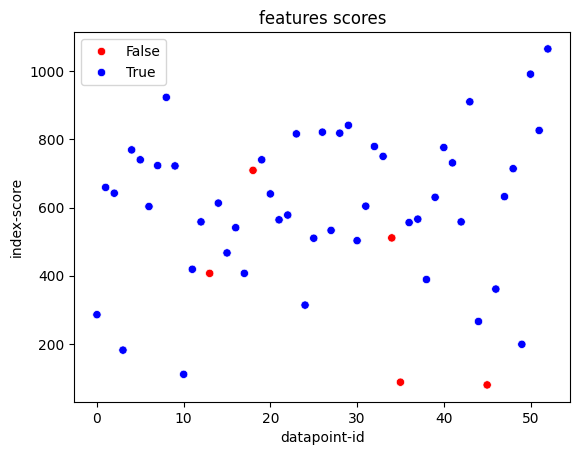

In [30]:
df['color'] = df['label'] == df['return_doc_id']

sns.scatterplot(data=df, x=df.index, y='idx_score', hue='color', palette=['red', 'blue'])
plt.xlabel('datapoint-id')
plt.ylabel('index-score')
plt.legend()
plt.title('features scores')
plt.show()


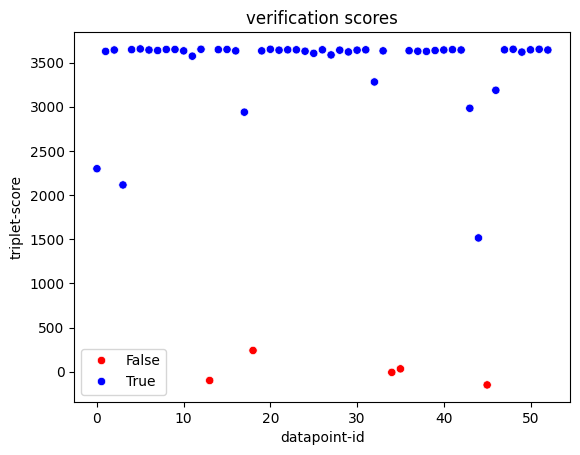

In [31]:
df['color'] = df['label'] == df['return_doc_id']

sns.scatterplot(data=df, x=df.index, y='verif_score', hue='color', palette=['red','blue'])
plt.xlabel('datapoint-id')
plt.ylabel('triplet-score')
plt.legend()
plt.title('verification scores')
plt.show()


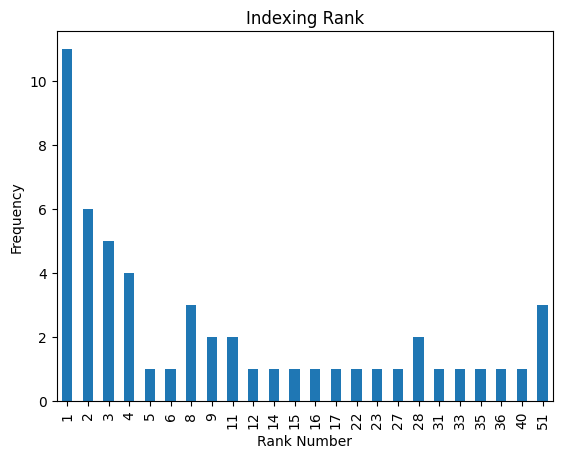

In [32]:
rank_counts = df['idx_rank'].value_counts().sort_index()

# Plot bar plot
rank_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Rank Number')
plt.ylabel('Frequency')
plt.title('Indexing Rank')

# Show the plot
plt.show()


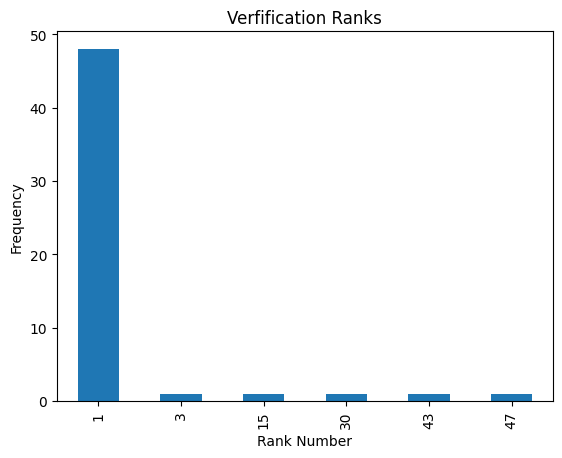

In [33]:
rank_counts = df['verif_rank'].value_counts().sort_index()

# Plot bar plot
rank_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Rank Number')
plt.ylabel('Frequency')
plt.title('Verfification Ranks')
# Show the plot
plt.show()
